In [1]:
import os
import pandas as pd
from azure.identity.aio import ManagedIdentityCredential
cred = ManagedIdentityCredential()
opts = {'account_name': 'datalakestorage7nrw9r', 'credential': cred, 'anon': False}
folder_path = "abfs://datalakegen2filesystem/analytics/connectedcar/chenha01/Churn/"

In [9]:
# read the files
# Mix Dataset 2022 and 2024. Train and Valid are from mix, Test is from 2024
train = pd.read_csv(folder_path + 'trainOneMonth_stratify.csv', delimiter=',', storage_options=opts)
test = pd.read_csv(folder_path + 'testOneMonth_stratify.csv', delimiter=',', storage_options=opts)
valid = pd.read_csv(folder_path + 'validOneMonth_stratify.csv', delimiter=',', storage_options=opts)

# read the files
# 2024 dataset only. All 3 files are from 2024
#train = pd.read_csv(folder_path + 'beforewoe_train_stratify.csv', delimiter=',', storage_options=opts)
#valid = pd.read_csv(folder_path + 'beforewoe_valid_stratify.csv', delimiter=',', storage_options=opts)
#test = pd.read_csv(folder_path + 'beforewoe_test_stratify.csv', delimiter=',', storage_options=opts)

In [5]:
# oversample the minority class in the training set
#positive = train[train['OneMonth_target'] == 1]
#negative = train[train['OneMonth_target'] == 0]
#train = pd.concat([positive.sample(n=negative.shape[0], replace=True), negative], axis=0)

In [10]:
len(train), len(valid), len(test)

(60880, 26092, 15846)

In [11]:
# drop TwoMonth_target
train.drop(columns=['TwoMonth_target'], inplace=True)

# drop features
train.drop(columns=['primary_package_id'], inplace=True)

# drop similar features (ages, states, etc)
train.drop(columns=['state', 'alternate_state'], inplace=True)
train.drop(columns=['combined_age', 'combined_dob', 'age_in_years_drv_numeric', 'exact_age_p1'], inplace=True)

# drop features generated by the model or scores
train.drop(columns=['last_activity_date_of_lu', 'move_update_date', 
                                            'cfi_investable_assets_score', 'cfi_net_asset_score', 
                                            'timesincesubjectphone1stseen', 'group_code','prospectsurvival_model',
                                            'marketing_risk_classifier_auto_score', 
                                            'marketing_risk_classifier_auto_decile', 'prospectsurvival_decile', 
                                            'timesinceprevaddrdate1stseen', 'cfi_investment_balances_score', 
                                            'exact_dob_drv_orig'], inplace=True)
train.drop(columns=['cape_ispsa', 'cfi_household_deposits_score', 'marketing_risk_index', 'scorerespmedsup'], inplace=True)
train.drop(columns=['scorerespfinalexpense', 'mes_score_zip9', 'life_attrition_model', 'unscrubbed_do_not_use_areacode'], inplace=True)
train.drop(columns=['liabilityresponsemodel', 'life_attrition_model_decile', 'channel_pref_d_score', 'alternate_geo_blk', 'prevaddrconfscore'], inplace=True)
train.drop(columns=['old', 'churn_fin_mth_error'], inplace=True)
train.drop(columns=['homeowner_probability_model', 'cfi_mortgage_refinance_score', 'cape_ispsa_decile_within_state', 'lastname36'], inplace=True)
train.drop(columns=['hisp_pct', 'hisp_score_drv', 'bk_score', 'channel_pref_e_score', 'channel_pref_i_score'], inplace=True)
train.drop(columns=['channel_pref_i_decile', 'channel_pref_d_decile', 'channel_pref_e_decile', 'activity_model'], inplace=True)
train.drop(columns=['activity_tile', 'premiummodelbase', 'premium_score', 'premium_decile', 'annuity_model'], inplace=True)
train.drop(columns=['annuity_decile_full', 'lifeclassification_model', 'lifeclassification_decile', 'mortgage_protection_model'], inplace=True)
train.drop(columns=['mortgage_protection_decile', 'scorerespltc'], inplace=True)

#train.drop(columns=['middle_name'], inplace=True)

In [29]:
# if the data type is object, change their data type to category
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].astype('category')

In [42]:
for col in valid.columns:
    if valid[col].dtype == 'object':
        valid[col] = valid[col].astype('category')

In [52]:
for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = test[col].astype('category')

In [13]:
# show all columns in train
for i in train.columns:
    print(i)

months_paying
statecode
drivercategory
countallvehicles
countallvehiclesaddedpast1mth
countallvehiclesaddedpast2mths
countallvehiclesaddedpast3mths
countallvehiclesaddedpast6mths
countallvehiclesaddedpast12mths
countallvehiclesaddedpast24mths
countallvehiclesaddedpast36mths
countallvehiclesaddedpast48mths
countallvehiclesaddedpast60mths
countallvehiclespurchasednew
countallvehiclespurchasednewaddedpast1mth
countallvehiclespurchasednewaddedpast2mths
countallvehiclespurchasednewaddedpast3mths
countallvehiclespurchasednewaddedpast6mths
countallvehiclespurchasednewaddedpast12mths
countallvehiclespurchasednewaddedpast24mths
countallvehiclespurchasednewaddedpast36mths
countallvehiclespurchasednewaddedpast48mths
countallvehiclespurchasednewaddedpast60mths
countallvehiclespurchasedused
countallvehiclespurchasedusedaddedpast1mth
countallvehiclespurchasedusedaddedpast2mths
countallvehiclespurchasedusedaddedpast3mths
countallvehiclespurchasedusedaddedpast6mths
countallvehiclespurchasedusedaddedpa

In [9]:
# feature selection train large number of models using small data sample, average the feature importance
# select the top features with highest importance
# drop the rest of the features
num_models = 50
sample_size = 10000
feature_importance = []
from xgboost.sklearn import XGBClassifier
def train_model_feature_selection(df, sample_size, label_name):
    # with replacement
    sample = df.sample(sample_size, replace=True)
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.5, 
                          colsample_bytree=0.5, enable_categorical = True, 
                          random_state=0)
    model.fit(sample.drop(columns=[label_name]), sample[label_name])
    return model.feature_importances_

for i in range(num_models):
    feature_importance.append(train_model_feature_selection(train, sample_size, 'OneMonth_target'))

In [10]:
# convert the list to dataframe
feature_importance_df = pd.DataFrame(feature_importance, columns=train.drop(columns=['OneMonth_target']).columns)
feature_importance_df = feature_importance_df.mean(axis=0)

In [11]:
# sort feature_importance_df by values and show the top 50 features
feature_importance_df = feature_importance_df.sort_values(ascending=False)

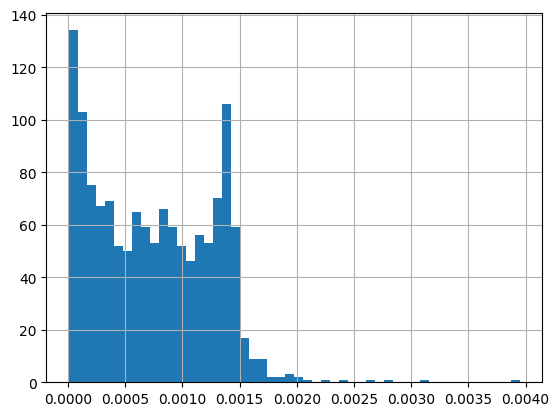

In [14]:
# remove the features with importance = 0
feature_importance_df = feature_importance_df[feature_importance_df > 0]
# select the top features with importance > 0.002
selected_features = feature_importance_df[feature_importance_df > 0.0015]
# distribution of feature importance
import matplotlib.pyplot as plt
feature_importance_df.hist(bins=50)
plt.show()

In [15]:
# show all selected_features
for feature in selected_features.index:
    print(feature)  

pctactivevehiclesaddedpast6mthderived
months_paying
pctactivevehiclesaddedpast12mthderived
age_drv
appfeatures
statecode
avg_lres
mdl_yr
vehicle_make_code_1
countallvehiclespurchasedusednonluxaddedpast24mths
p1_occupation_group_v2
addrs_15yr
monthstenureactiveveha
veh_age
arc_penetration_range_whitecollar
coveragetier
income_code_drv
income_level
base_price
avgmonthstenureallvehiclesderived
household_composition
price_now
model_year
countallvehiclespurchasedusedchevrolet
summonthstenureactivevehicles
inq_count24
arc_car
vehicle_class_1
avg_mo_per_addr
pctdisposedvehiclesremovedpast12mthderived
vehicle_style_1
arc_mhv
summonthstenureallvehiclessamepower
pctdisposedvehiclesremovedpast6mthderived
inq_highriskcredit
enh_mktval_drv_orig
combined_ownership_code
vehicle_body_1
summonthstenuredisposedveha
vehicle_age
dwelling_unit_size
numsrcsconfirmidaddr
v1_resinputavmvalue12mo
summonthstenureallvehb
pctpurchasednewincreasederived
avgmonthstenuremostrecent3disposedvehiclesderived
pctallvehic

In [58]:
# 66 final features
len(selected_features)
# save the selected features
selected_features = selected_features.reset_index()
#selected_features.to_csv(folder_path + 'tree_selected_features.csv', header=False, index=False, storage_options=opts)

#selected_features.to_csv(folder_path + 'tree_selected_features_using2024DataOnly.csv', header=False, index=False, storage_options=opts)

In [58]:
# read the selected features
selected_features = pd.read_csv(folder_path + 'tree_selected_features.csv', header=None, storage_options=opts)
#selected_features = pd.read_csv(folder_path + 'tree_selected_features_using2024DataOnly.csv', header=None, storage_options=opts)

In [59]:
# convery the selected features to a list
selected_features = selected_features[0].tolist()
# add the target column to the selected features
selected_features.append('OneMonth_target')

In [17]:
# convery the selected features to a list
#selected_features = selected_features.index.tolist()
# add the target column to the selected features
#selected_features.append('OneMonth_target')

In [60]:
# keep the selected features only in train, test, valid
# add the OneMonth_target back to selected_features
#train = train[selected_features]
#test = test[selected_features]
#valid = valid[selected_features]

In [14]:
import numpy as np
def top_to_bottom_lift(y_true, y_pred):
    # combine the y_true and y_pred into a dataframe
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    # sort the dataframe by y_pred
    df = df.sort_values(by='y_pred', ascending=False)
    # group rows into 10 groups with same number of rows
    df['decile'] = pd.qcut(df['y_pred'], 10, labels=False)
    # calculate the number of samples in each decile
    n_samples = len(y_true)
    decile_size = n_samples // 10
    # print row counts in each decile
    # print(df['decile'].value_counts().sort_index())
    # calculate how many positive samples are in the top decile
    top_decile_size = np.sum(df[df['decile'] == 9]['y_true'])
    lift_top_decile = top_decile_size / decile_size
    # calculate the mean of the bottom decile
    bottom_decile_size = np.sum(df[df['decile'] == 0]['y_true'])
    lift_bottom_decile = bottom_decile_size / decile_size
    # calculate the lift
    lift = lift_top_decile / lift_bottom_decile
    return lift

In [15]:
from sklearn.metrics import make_scorer
lift_scorer = make_scorer(top_to_bottom_lift, greater_is_better=True, needs_proba=True)

/anaconda/envs/cc_py310_chenha01/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [16]:
scale_pos_weight = len(train[train['OneMonth_target'] == 0]) / len(train[train['OneMonth_target'] == 1])

In [22]:
# import grid search
from sklearn.model_selection import GridSearchCV
# import Extreme boosting classifier
import xgboost 
from xgboost.sklearn import XGBClassifier
parama_test1 = {
    #'n_estimators' : [200, 300, 400, 500],
    'max_depth':[7, 15, 30],
    #'min_child_weight':range(1,10,2),
}


gs1 = GridSearchCV(estimator=XGBClassifier(scale_pos_weight = scale_pos_weight, learning_rate=0.01, n_estimators=200, max_depth=7,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, seed=27, enable_categorical=True),
param_grid = parama_test1, scoring = lift_scorer,n_jobs=-1, cv=5)

gs1.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

gs1.best_params_, gs1.best_score_

({'max_depth': 30}, 3.6638482927747384)

In [23]:
gs1.best_params_, gs1.best_score_

({'max_depth': 30}, 3.6638482927747384)

In [24]:
# use the best parameters to train the model
#gs1 = XGBClassifier(scale_pos_weight = scale_pos_weight, learning_rate=0.1, n_estimators=140, max_depth=9,
#                                        min_child_weight=1, gamma=0.4, subsample=0.9, colsample_bytree=0.7,
#                                        objective= 'binary:logistic', nthread=-1, seed=27, enable_categorical=True)
gs1 = XGBClassifier(scale_pos_weight = scale_pos_weight, learning_rate=0.01, n_estimators=200, max_depth=30,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, seed=27, enable_categorical=True)
gs1.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

In [25]:
OneMonth_target_test = test['OneMonth_target']

In [26]:
OneMonth_target_valid = valid['OneMonth_target']

In [46]:
valid['pred'] = gs1.predict_proba(valid[train.columns].drop(columns=['OneMonth_target']))[:, 1]
valid['OneMonth_target'] = OneMonth_target_valid
# sort prob in order
valid.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid['group'] = pd.qcut(valid['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

3.524242424242424

In [47]:
test['pred'] = gs1.predict_proba(test[train.columns].drop(columns=['OneMonth_target']))[:, 1]
test['OneMonth_target'] = OneMonth_target_test
# sort prob in order
test.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test['group'] = pd.qcut(test['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

3.9351351351351354

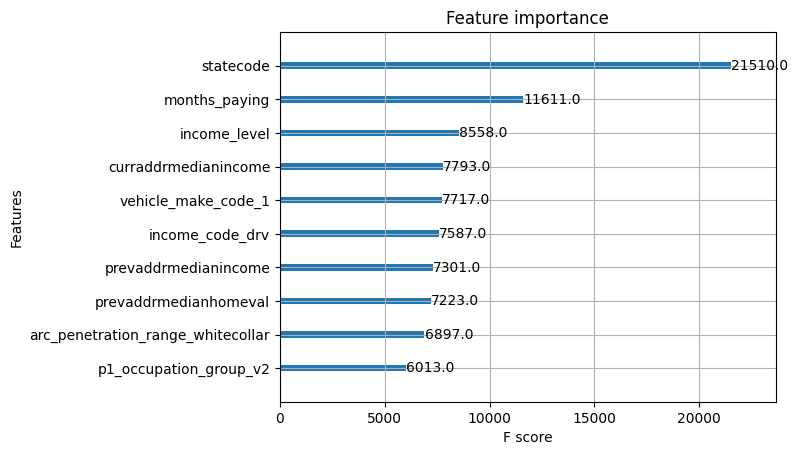

In [49]:
# get the gs1 most important features
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(gs1, max_num_features=10)
plt.show()

In [57]:
# get gs1 confusion matrix
from sklearn.metrics import confusion_matrix
# drop pred and group if they are in the test
OneMonth_target_test = test['OneMonth_target']
if 'pred' in test.columns:
    test.drop(columns=['pred', 'group'], inplace=True)
confusion_matrix(OneMonth_target_test, gs1.predict(test[train.columns].drop(columns=['OneMonth_target'])))

# get f1 score
from sklearn.metrics import f1_score
f1_score(OneMonth_target_test, gs1.predict(test[train.columns].drop(columns=['OneMonth_target'])))

0.12216547497446374

In [59]:
# import grid search
from sklearn.model_selection import GridSearchCV
# import gradient boosting classifier
# import Extreme boosting classifier
import xgboost 
from xgboost.sklearn import XGBClassifier
parama_test2 = {
    #'learning_rate': [0.01, 0.05, 0.001],
    'min_child_weight':range(1,10,2)
}

gs2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.01, n_estimators=200, max_depth=30,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=scale_pos_weight, seed=27, enable_categorical=True),
param_grid = parama_test2, scoring = lift_scorer,n_jobs=-1, cv=5)

gs2.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

gs2.best_params_, gs2.best_score_

({'min_child_weight': 7}, 3.7770344194594356)

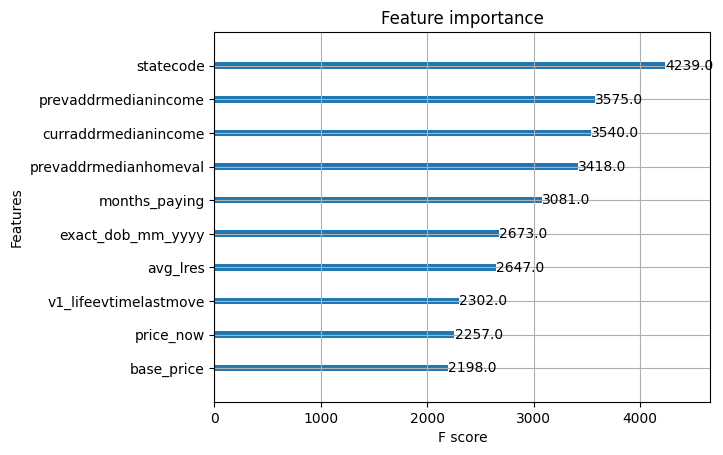

In [60]:
# get the gs1 most important features
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(gs2.best_estimator_, max_num_features=10)
plt.show()

In [61]:
valid['pred'] = gs2.predict_proba(valid[train.columns].drop(columns=['OneMonth_target']))[:, 1]
valid['OneMonth_target'] = OneMonth_target_valid
# sort prob in order
valid.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid['group'] = pd.qcut(valid['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

3.3529411764705888

In [63]:
test['pred'] = gs2.predict_proba(test[train.columns].drop(columns=['OneMonth_target']))[:, 1]
test['OneMonth_target'] = OneMonth_target_test
# sort prob in order
test.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test['group'] = pd.qcut(test['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

3.9789473684210526

{'gamma': 0.0}
3.8117471988795515


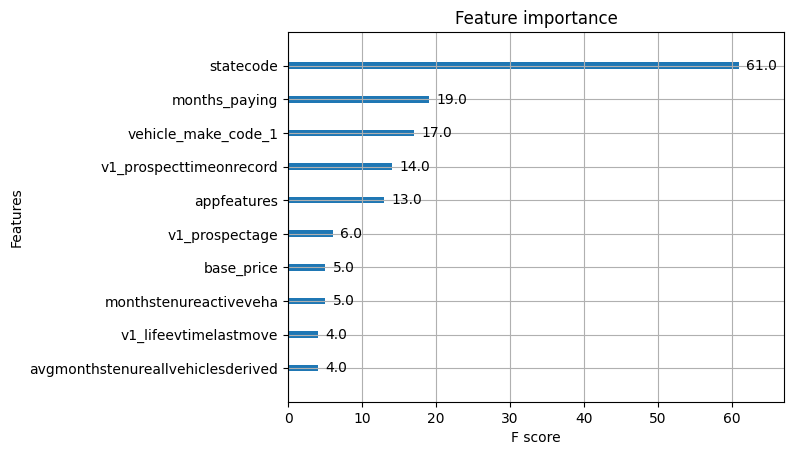

In [125]:
# import grid search
from sklearn.model_selection import GridSearchCV
# import gradient boosting classifier
# import Extreme boosting classifier
import xgboost 
from xgboost.sklearn import XGBClassifier
parama_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gs3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=30, max_depth=3,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, enable_categorical=True),
param_grid = parama_test3, scoring = lift_scorer,n_jobs=-1, cv=5)

gs3.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

print(gs3.best_params_)
print(gs3.best_score_)

# get the gs1 most important features
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(gs3.best_estimator_, max_num_features=10)
plt.show()

/anaconda/envs/cc_py310_chenha01/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/anaconda/envs/cc_py310_chenha01/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/anaconda/envs/cc_py310_chenha01/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/anaconda/envs/cc_py310_chenha01/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/tmp/ipykernel_4739/4019157447.py", line 8, in top_to_bottom_lift
  File "/anaconda/envs/cc_py310_chenha01/lib/python3.10/site-packages/pa

{'colsample_bytree': 0.8, 'subsample': 0.8}
3.945291331393027


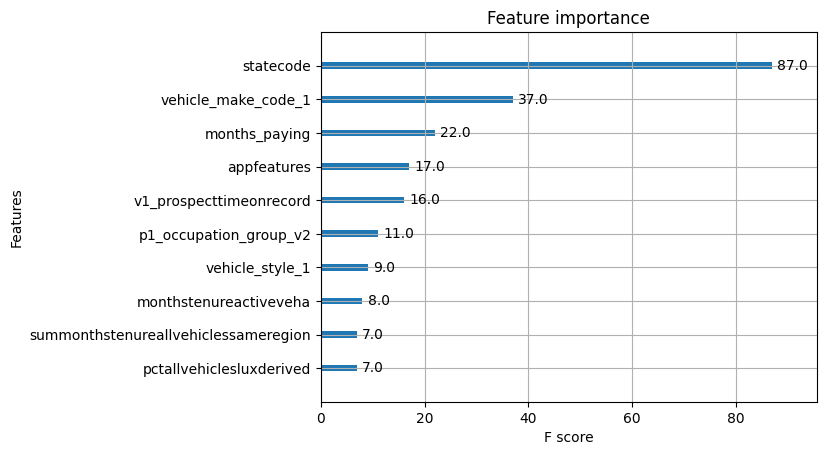

In [126]:
# import grid search
from sklearn.model_selection import GridSearchCV
import xgboost 
from xgboost.sklearn import XGBClassifier
parama_test4 = {
    'subsample':[i/10.0 for i in range(0,10)], 
    'colsample_bytree':[i/10.0 for i in range(0,10)]
}

gs4= GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=3,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, enable_categorical=True),
param_grid = parama_test4, scoring = lift_scorer,n_jobs=-1, cv=5)

gs4.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

print(gs4.best_params_)
print(gs4.best_score_)

# get the gs1 most important features
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(gs4.best_estimator_, max_num_features=10)
plt.show()

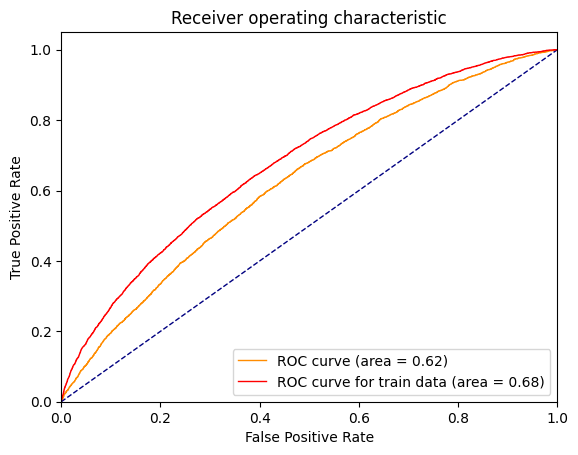

In [127]:
# get roc curve for the best model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
test.drop(columns=['group', 'pred'], inplace=True)
fpr, tpr, thresholds = roc_curve(test['OneMonth_target'], gs4.predict_proba(test.drop(columns=['OneMonth_target']))[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# include roc curve for train data in the same plot
fpr, tpr, thresholds = roc_curve(train['OneMonth_target'], gs4.predict_proba(train.drop(columns=['OneMonth_target']))[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve for train data (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [128]:
test.drop(columns=['OneMonth_target'], inplace=True)
test['pred'] = gs4.predict_proba(test)[:, 1]
test['OneMonth_target'] = OneMonth_target_test
# sort prob in order
test.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test['group'] = pd.qcut(test['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

3.43

In [129]:

valid['pred'] = gs4.predict_proba(valid[selected_features])[:, 1]
valid['OneMonth_target'] = OneMonth_target_valid
# sort prob in order
valid.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid['group'] = pd.qcut(valid['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

2.2191011235955056

{'reg_alpha': 0.01, 'reg_lambda': 1}
3.949164695263788


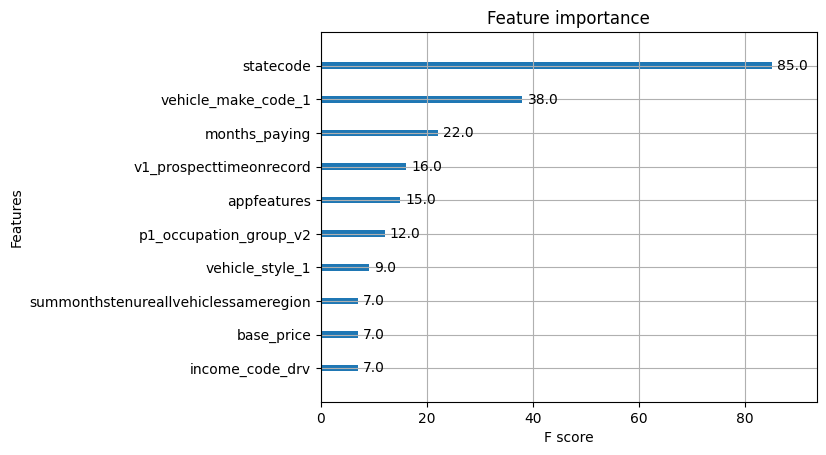

In [11]:
# import grid search
from sklearn.model_selection import GridSearchCV
import xgboost 
from xgboost.sklearn import XGBClassifier
parama_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10], 
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 10]
}

gs5= GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=3,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, enable_categorical=True),
param_grid = parama_test5, scoring = lift_scorer,n_jobs=-1, cv=5)

gs5.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

print(gs5.best_params_)
print(gs5.best_score_)

# get the gs1 most important features
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(gs5.best_estimator_, max_num_features=10)
plt.show()

In [12]:
OneMonth_target_test = test['OneMonth_target']

In [14]:
#test.drop(columns=['OneMonth_target'], inplace=True)
test['pred'] = gs5.predict_proba(test)[:, 1]
test['OneMonth_target'] = OneMonth_target_test
# sort prob in order
test.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test['group'] = pd.qcut(test['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

3.43

In [15]:
OneMonth_target_valid = valid['OneMonth_target']

In [20]:

valid['pred'] = gs5.predict_proba(valid[selected_features])[:, 1]
valid['OneMonth_target'] = OneMonth_target_valid
# sort prob in order
valid.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid['group'] = pd.qcut(valid['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

2.254335260115607

{'reg_alpha': 1e-05}
3.6317686099439483


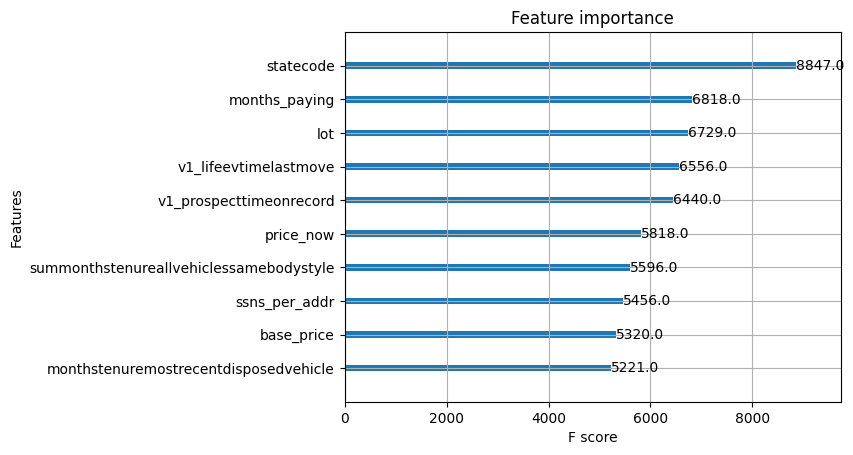

In [58]:
# import grid search
from sklearn.model_selection import GridSearchCV
import xgboost 
from xgboost.sklearn import XGBClassifier
parama_test5 = {
    'reg_alpha':[1e-5]
}

gs5= GridSearchCV(estimator=XGBClassifier(learning_rate=0.04289967993214081, n_estimators=484, max_depth=12,
                                        min_child_weight=1, gamma=2.3597103175363897e-08, subsample=0.8254492263720205, 
                                        colsample_bytree=0.6941808093133581, reg_alpha=0.5671193243162964, 
                                        reg_lambda=0.016796237389527194, 
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, enable_categorical=True),
param_grid = parama_test5, scoring = lift_scorer,n_jobs=-1, cv=5)

gs5.fit(train.drop(columns=['OneMonth_target']), train['OneMonth_target'])

print(gs5.best_params_)
print(gs5.best_score_)

# get the gs1 most important features
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(gs5.best_estimator_, max_num_features=10)
plt.show()

In [61]:
selected_features.remove('OneMonth_target')

In [68]:
OneMonth_target_valid = valid['OneMonth_target']

In [69]:
valid['pred'] = gs5.predict_proba(valid[selected_features])[:, 1]
valid['OneMonth_target'] = OneMonth_target_valid
# sort prob in order
valid.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
valid['group'] = pd.qcut(valid['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = valid.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

2.5274725274725274

In [70]:
OneMonth_target_test = test['OneMonth_target']

In [73]:
test['pred'] = gs5.predict_proba(test[selected_features])[:, 1]
test['OneMonth_target'] = OneMonth_target_test
# sort prob in order
test.sort_values(by='pred', ascending=True, inplace=True)
# group rows into 10 groups with same number of rows
test['group'] = pd.qcut(test['pred'], 10, labels=False)
# group by group, calculate the sum of OneMonth_target and count of OneMonth_target
test_group = test.groupby('group').agg({'OneMonth_target': 'sum', 'pred': 'count'}).reset_index()
# calculate rate of OneMonth_target by OneMonth_target /  pred
test_group['rate'] = test_group['OneMonth_target'] / test_group['pred']
# get rate of OneMonth_target from group as 0
rate_0 = test_group[test_group['group'] == 0]['rate'].values[0]
rate_9 = test_group[test_group['group'] == 9]['rate'].values[0]
rate_9 / rate_0

2.7754237288135593

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming your DataFrames are named `train`, `valid`, `test` and have features and OneMonth_target
X_train, y_train = train.drop(columns=['OneMonth_target']), train['OneMonth_target']
X_valid, y_valid = valid.drop(columns=['OneMonth_target']), valid['OneMonth_target']
X_test, y_test = test.drop(columns=['OneMonth_target']), test['OneMonth_target']

# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': scale_pos_weight,  # Adjust class weight
        'eval_metric': 'auc'  # Add eval_metric here
    }
    
    model = XGBClassifier(**param, use_label_encoder=False, enable_categorical=True)
    
    # Fit model on training data and use validation data for early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    
    # Predict on the validation set
    y_pred_valid = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred_valid)
    
    return accuracy

# Create a study and optimize it
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
